In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dtaidistance import ed

In [2]:
offsets1 = np.random.random(size = 10)
offsets2 = np.random.random(size = 10)

In [3]:
x_ax = np.linspace(-5,5,100)

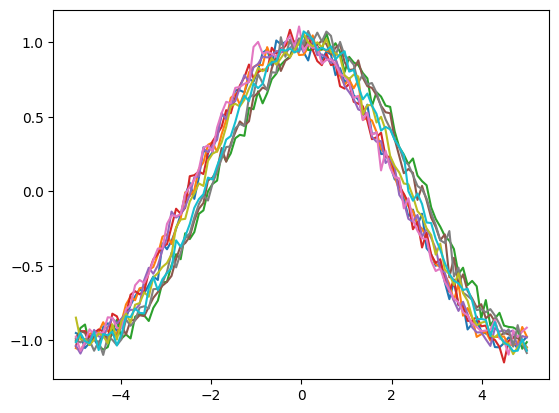

In [4]:
signal1 = [np.sin((2+x_ax+offsets1[i])/1.5) + np.random.normal(size=100, scale = 0.05) for i in range(10)]
for i in signal1:
    plt.plot(x_ax,i)


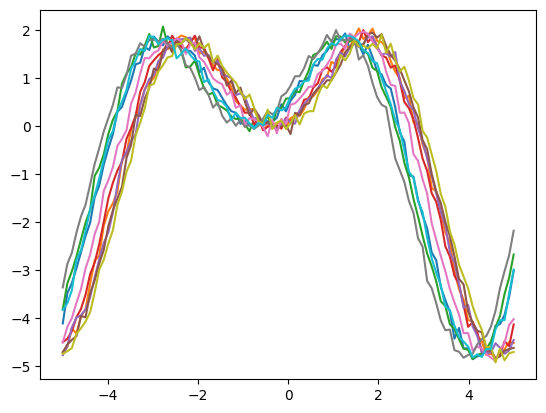

In [5]:
signal2 = [np.sin(x_ax+offsets2[i])*(x_ax+offsets2[i]) + np.random.normal(size=100, scale = 0.1) for i in range(10)]
for i in signal2:
    plt.plot(x_ax,i)

In [16]:
data_gathered = [[signal1,0],[signal2,1]]

In [6]:
def GenerateCandidates(Ts, min, max):
    ans = []
    for i in range(min, max+1):
        for j in range(len(Ts)-i+1):
            ans.append(Ts[j:j+i])
    return ans

In [7]:
def CalculateDistance(Ts, fortochka):
    size = len(fortochka)
    min_dist = 10**12
    for i in range(len(Ts)-size+1):
        dist = ed.distance(fortochka,Ts[i:size+i])
        if dist<min_dist:
            min_dist = dist
    return min_dist

In [10]:
def assess_quality(distances):
    total = np.zeros(2) # 2 класса
    for ts in distances:
        total[ts[1]] += 1
    p_total = -np.sum([np.log(np.power(total[i] / len(distances), total[i] / len(distances))) for i in np.arange(len(total))])
    l = np.zeros(2)
    r = np.zeros(2)
    for ts in distances:
        r[ts[1]] += 1
    inf_gain = p_total 
    for i in range(1, len(distances)):
        l[distances[i - 1][1]] += 1
        r[distances[i - 1][1]] -= 1
        p_left = np.sum([np.log(np.power(l[i] / len(distances), l[i] / len(distances))) for i in np.arange(len(l))])
        p_right = np.sum([np.log(np.power(r[i] / len(distances), r[i] / len(distances))) for i in np.arange(len(r))])
        inf_gain = max(inf_gain, p_left * i / len(distances) + p_right * (len(distances) - i) / len(distances))
    return p_total + inf_gain

In [21]:
def shapelet_cached_selection(num, minlen, maxlen):
    
    # In further code I'll use array [value, left_border, right_border]    
    
    k = 0
    for ts_mark in num:
        for ts in ts_mark[0]:
            a,b = len(ts) - maxlen + 1, len(ts) - minlen + 1
            k += (a+b)*(abs(a-b))/2
    k = int(k * 0.001) # top 0.1% best shapelets for each time series
    print(k)
    k_shapelets = []
    class_count = 2
    for ts_mark in num:
        for ts in ts_mark[0]:
            shapelets = []
            for l in range(minlen, maxlen + 1):
                for i in range(len(ts) - l + 1):
                    shapelet = [ts[i:i + l], i, i + l - 1]
                    distances = []
                    for i in range(len(num)):
                        for j in range(len(num[i][0])):
                            distances.append([CalculateDistance(num[i][0][j], shapelet[0]), num[i][1]])
                    distances = sorted(distances, key=(lambda x: x[0]))
                    quality = assess_quality(distances)
                    shapelets.append([quality, shapelet])
            print(len(shapelets))
            shapelets = sorted(shapelets, key=(lambda x: -x[0]))
            i = 1
            ids = []
            for i in range(len(shapelets)):
                f = True
                for j in ids:
                    flr = shapelets[i][1][2] <= shapelets[j][1][1]
                    frl = shapelets[j][1][2] <= shapelets[i][1][1]
                    f = frl or flr
                    if not(f):
                        break
                if f:
                    ids.append(i)
            for i in ids:
                k_shapelets.append(shapelets[i])
    k_shapelets = sorted(k_shapelets, key=(lambda x: x[0]))[:k]
    return (lambda x: np.array([x[i][1][0] for i in np.arange(len(x))]))(k_shapelets)

In [22]:
shapelets = shapelet_cached_selection(data_gathered, 15, 75)

67
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416


67


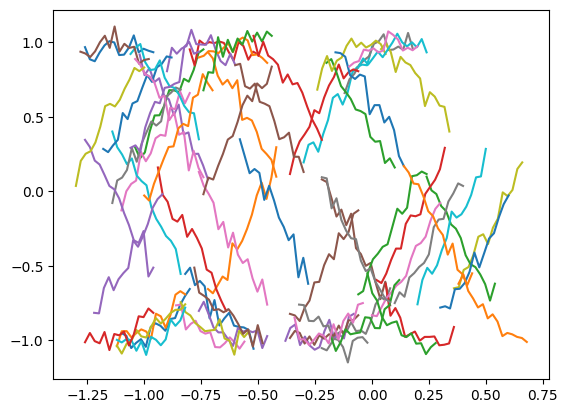

In [23]:
print(len(shapelets))
for s in shapelets:
    t = np.random.randint(100 - len(s))
    plt.plot(np.linspace((t - len(s) - 50) / 50, (t - 50) / 50, len(s)), s)
plt.show()

In [29]:
X = []
for x in data_gathered[0][0]:
    X.append(np.array([CalculateDistance(x, s) for s in shapelets]))
for x in data_gathered[1][0]:
    X.append(np.array([CalculateDistance(x, s) for s in shapelets]))
y = [0]*10+[1]*10

X_train = []
X_test = []
y_train = []
y_test = []

for i in range(7):
    X_train.append(X[i])
    y_train.append(y[i])
    X_train.append(X[i+10])
    y_train.append(y[i+10])

for i in range(7, 10):
    X_test.append(X[i])
    y_test.append(y[i])
    X_test.append(X[i+10])
    y_test.append(y[i+10])


print(y_train)
print(y_test)

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 1]


In [30]:
from pyts.classification import TimeSeriesForest
 
clf = TimeSeriesForest()
clf.fit(X_train, y_train)

print("--- Классификатор TimeSeriesForest ---\n")
print(f"Accuracy = {clf.score(X_test, y_test)}")
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}\n")

--- Классификатор TimeSeriesForest ---

Accuracy = 1.0
Вектор вероятности принадлежности к классам [[0.972 0.028]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0.002 0.998]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0.984 0.016]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0.002 0.998]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0.996 0.004]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0.004 0.996]]
Истинный класс для предсказаний 1

